# TODO
Models to add: wide MLP or another DL model (hugging face or custom)
<hr>
otestovat potom na llame mby 
<hr>
vygenerovat cca 100 edge case dat
"What are the laws for ..bullshit..", through validation
<hr>
lepsi open-domain dataset vytvorit, nejake general questions/prompts, moc odborne som zobral
 
https://huggingface.co/datasets/nomic-ai/gpt4all-j-prompt-generations

In [1]:
from llm_classifier import LMTrainer, LMClassifier
from svm_tfidf import SVMClassifier
from fasttext_model import *
from utilities import *
import os
import dotenv
import requests
import fasttext
from fastembed import TextEmbedding
from tqdm import tqdm
import re
import nltk

nltk.download('stopwords', download_dir=os.path.join(os.path.dirname('../.venv/'), 'nltk_data'))
nltk.download('punkt_tab', download_dir=os.path.join(os.path.dirname('../.venv/'), 'nltk_data'))
nltk.download('wordnet', download_dir=os.path.join(os.path.dirname('../.venv/'), 'nltk_data'))

dotenv.load_dotenv()

c:\Users\riso\Desktop\Prompt-Classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to ../.venv\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to ../.venv\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to ../.venv\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
open_path = "../data/open_domain_data.csv"
specific_path = "../data/specific_domain_data.csv"

train_size = 10_000
test_size = 10_000
val_size = 1000

random.seed(42)

In [3]:
open_data = pd.read_csv(open_path)
specific_data = pd.read_csv(specific_path)

open_data = open_data[:15_000]
specific_data = specific_data[:15_000]

merged_data = pd.concat([open_data, specific_data])

shuffled_data = merged_data.sample(frac=1).reset_index(drop=True)

shuffled_data['question'] = (
    shuffled_data['question']
    .apply(lambda x: re.sub(r'[^\w\s]', '', x.encode('utf-8').decode('utf-8').lower()))
)

train_data = shuffled_data[:train_size]
val_data = shuffled_data[train_size:train_size + val_size]
test_data = shuffled_data[train_size:train_size + test_size]

# Models

In [4]:
def get_models() -> list:
    url = f"{os.getenv("PROXY_URL")}/models"
    headers = {"Content-Type": "application/json", "Authorization": f"Bearer {os.getenv("OPENAI_API_KEY")}"}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        models = response.json()
        models = [model["id"] for model in models["data"]]
        return models
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
available_models = get_models()
if available_models:
    print("Available models:", available_models)
else:
    print("Failed to retrieve models")

Available models: ['gpt-4o', 'llama3.1:70b', 'llama3.1:8b', 'o1-mini', 'o1-preview', 'gpt-4', 'gpt-4o-mini', 'gpt-4-turbo']


# Embedding Models

In [5]:
baai_embedding = TextEmbedding(model_name="BAAI/bge-small-en-v1.5")
jina_embedding = TextEmbedding(model_name="jinaai/jina-embeddings-v2-small-en")
miniLM_embedding = TextEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


# GPT-4o-mini

In [ ]:
api_key = os.getenv("OPENAI_API_KEY")
proxy_url = os.getenv("PROXY_URL")

gpt_model = LMClassifier(api_key=api_key, proxy_url=proxy_url, domain='law', model_name='gpt-4o-mini', train_size=100, test_size=300)
gpt_model.load_data(train_data=train_data, test_data=test_data)

trainer = LMTrainer(gpt_model.train_data)

In [ ]:
predictions = []
true_labels = []
total_cost = 0

compiled_model = trainer.optimize_model()

for example in tqdm(gpt_model.test_data):
    prediction = trainer.optimized_model(prompt=example.prompt, domain=example.domain).label
    predictions.append(prediction)
    true_labels.append(example.label)
    total_cost += calculate_prompt_cost(example.prompt+example.domain, completion=prediction, model_name=gpt_model.model_name)

f1, accuracy, recall, precision = trainer.evaluate(predictions, true_labels)

print(f"Total cost is: {total_cost:.8f}$")
print(f"F1 score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

trainer.save_model(f"../models/{gpt_model.model_name}.json")

# SVM-TFIDF

In [6]:
train_data = preprocess_data(train_data)

config = {
    'C': 0.05,
    'embedding_model': baai_embedding,
}

svm_classifier = SVMClassifier(config=config)

X_train, X_test, y_train, y_test = train_data['question'], test_data['question'], train_data['label'], test_data['label']

X_train = list(config.get('embedding_model').embed(X_train))
X_test = list(config.get('embedding_model').embed(X_test))

c:\Users\riso\Desktop\Prompt-Classification\src\utilities.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['question'] = data['question'].apply(clean_text)


Training complete


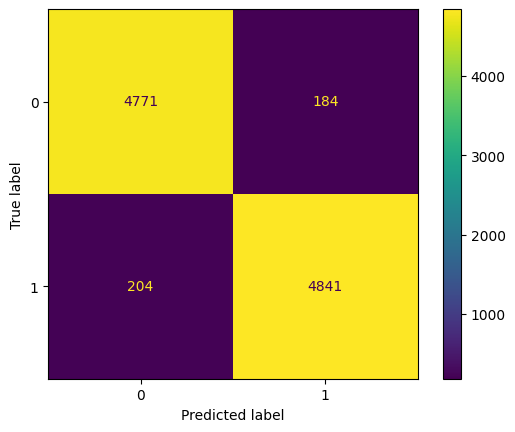

F1 score: 0.96
Accuracy: 0.96
Recall: 0.96
Precision: 0.96


In [7]:
svm_classifier.train(X_train, y_train)
print("Training complete")

f1, accuracy, recall, precision = svm_classifier.evaluate(X_test, y_test)
print(f"F1 score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")

In [8]:
# Save the model
svm_classifier.save_model(model_path=f'../models/{svm_classifier.model_name}.joblib')

Model saved to ../models/SVM_TFIDF.joblib


# FastText

In [9]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [10]:
fasttext_model = FastText(train_data=train_data[:5000], test_data=test_data)

train_file = "../data/fasttext_train.txt"
test_file = "../data/fasttext_test.txt"

fasttext_model.preprocess_data(train_path=train_file, test_path=test_file)

In [11]:
ft_model = fasttext.train_supervised(train_file)
print_results(*ft_model.test(test_file))

N	10000
P@1	0.907
R@1	0.907


In [12]:
ft_model.save_model(f"../models/{fasttext_model.model_name}.bin")